# AHP Calculation


In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import eig

# Random Index (RI) values based on matrix size (1 to 10 criteria)
RI = {1: 0.0, 2: 0.0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}

default_ci_threshold = 1.5

# Response scale AHP (saaty scale)
response_scale_ahp = {
    "A mutlak lebih penting dibandingkan B": 9,
    "A sangat lebih penting dibandingkan B": 7,
    "A cukup lebih penting dibandingkan B": 5,
    "A sedikit lebih penting dibandingkan B": 3,
    "Sama pentingnya": 1,
    "B sedikit lebih penting dibandingkan A": 1/3,
    "B cukup lebih penting dibandingkan A": 1/5,
    "B sangat lebih penting dibandingkan A": 1/7,
    "B mutlak lebih penting dibandingkan A": 1/9
}
n = 4

# saaty
# scale = lambda x: x

# balanced
# scale = lambda x: (9 + x)/(11-x)

# generalized balanced
scale = lambda x: ((n-1)*x+9)/(9 + n - x) # generalized balanced

# Response scale balanced
response_scale_balanced = {
    "A mutlak lebih penting dibandingkan B": scale(9),
    "A sangat lebih penting dibandingkan B": scale(7),
    "A cukup lebih penting dibandingkan B": scale(5),
    "A sedikit lebih penting dibandingkan B": scale(3),
    "Sama pentingnya": scale(1),
    "B sedikit lebih penting dibandingkan A": 1/scale(3),
    "B cukup lebih penting dibandingkan A": 1/scale(5),
    "B sangat lebih penting dibandingkan A": 1/scale(7),
    "B mutlak lebih penting dibandingkan A": 1/scale(9),
}

print(response_scale_balanced)

# Criteria definitions
ppt_criteria = ["People", "Process", "Technology"]
ppt_criteria_pairs = [
    "3. A: People. B: Process",
    "4. A: People. B: Technology",
    "5. A: Process. B: Technology"
]

people_criteria = [
    "Dukungan manajemen senior",
    "Alokasi sumber daya",
    "Kompatibilitas Teknologi",
    "Perubahan manajemen dan Adaptasi User"
]

people_criteria_pairs = [
    f"7. A: {people_criteria[0]}. B: {people_criteria[1]}",
    f"8. A: {people_criteria[0]}. B: {people_criteria[2]}",
    f"9. A: {people_criteria[0]}. B: {people_criteria[3]}",
    f"10. A: {people_criteria[1]}. B: {people_criteria[2]}",
    f"11. A: {people_criteria[1]}. B: {people_criteria[3]}",
    f"12. A: {people_criteria[2]}. B: {people_criteria[3]}"
]

process_criteria = [
    "Rekayasa ulang proses bisnis",
    "Kebutuhan sistem yang jelas",
    "Standar operasional yang jelas",
    "Mitigasi dan manajemen risiko"
]

process_criteria_pairs = [
    f"14. A: {process_criteria[0]}. B: {process_criteria[1]}",
    f"15. A: {process_criteria[0]}. B: {process_criteria[2]}",
    f"16. A: {process_criteria[0]}. B: {process_criteria[3]}",
    f"17. A: {process_criteria[1]}. B: {process_criteria[2]}",
    f"18. A: {process_criteria[1]}. B: {process_criteria[3]}",
    f"19. A: {process_criteria[2]}. B: {process_criteria[3]}"
]

technology_criteria = [
    "Keamanan yang kuat",
    "Skalabilitas infrastruktur IT",
    "Integrasi Sistem",
    "Performa dan kecepatan sistem"
]

technology_criteria_pairs = [
    f"21. A: {technology_criteria[0]}. B: {technology_criteria[1]}",
    f"22. A: {technology_criteria[0]}. B: {technology_criteria[2]}",
    f"23. A: {technology_criteria[0]}. B: {technology_criteria[3]}",
    f"24. A: {technology_criteria[1]}. B: {technology_criteria[2]}",
    f"25. A: {technology_criteria[1]}. B: {technology_criteria[3]}",
    f"26. A: {technology_criteria[2]}. B: {technology_criteria[3]}"
]

cr_values = []

# Function to build pairwise comparison matrix
def build_matrix(row, pairs, criteria, response_scale):
    n = len(criteria)
    matrix = np.ones((n, n))  # Start with identity matrix
    for i, crit_a in enumerate(criteria):
        for j, crit_b in enumerate(criteria):
            if i < j:
                pairwise_key = next(
                    (pair for pair in pairs if f"A: {crit_a}. B: {crit_b}" in pair), None
                )
                if pairwise_key and pairwise_key in row and row[pairwise_key] in response_scale:
                    weight = response_scale[row[pairwise_key]]
                    matrix[i, j] = weight
                    matrix[j, i] = 1 / weight
    return matrix

# Calculate Consistency Index (CI)
def calculate_ci(matrix):
    n = matrix.shape[0]
    eigvals, _ = eig(matrix)
    lambda_max = max(eigvals.real)
    ci = (lambda_max - n) / (n - 1)
    return ci

def calculate_cr(matrix):
    ci = calculate_ci(matrix)  # Calculate Consistency Index
    n = matrix.shape[0]  # Number of criteria
    cr = ci / RI[n] if n in RI else float('inf')  # Calculate Consistency Ratio
    return cr

# Clean data based on CI threshold
def clean_data(data, pairs, criteria, response_scale=response_scale_ahp, threshold=default_ci_threshold):
    valid_responses = []
    for _, row in data.iterrows():
        matrix = build_matrix(row, pairs, criteria, response_scale)
        ci = calculate_ci(matrix)
        cr = ci / RI[len(criteria)] if len(criteria) in RI else float('inf')
        print(f"R{row['No.']},{cr:.8f}")
        if cr <= threshold:
            valid_responses.append(row)
        # else:
        #     print(f"Response {row['Response ID']} from {row['1. Profil Responden']} has a CR of {cr}")
    return pd.DataFrame(valid_responses)

# Calculate priority vector
def calculate_priority_vector(matrix):
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)
    priority_vector = normalized_matrix.mean(axis=1)
    return priority_vector

{'A mutlak lebih penting dibandingkan B': 9.0, 'A sangat lebih penting dibandingkan B': 5.0, 'A cukup lebih penting dibandingkan B': 3.0, 'A sedikit lebih penting dibandingkan B': 1.8, 'Sama pentingnya': 1.0, 'B sedikit lebih penting dibandingkan A': 0.5555555555555556, 'B cukup lebih penting dibandingkan A': 0.3333333333333333, 'B sangat lebih penting dibandingkan A': 0.2, 'B mutlak lebih penting dibandingkan A': 0.1111111111111111}


In [2]:
# Main Script
file_path = "~/Downloads/export-core_banking_system_csf_survey-2024-12-01-08-19-25.csv"
data = pd.read_csv(file_path)
data = data.applymap(lambda x: x.replace('\t', ' ') if isinstance(x, str) else x)
data = data.rename(columns={
    '10. A: Alokasi sumber daya . B: Kompatibilitas Teknologi': '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
    '11. A: Alokasi sumber daya . B: Perubahan manajemen dan Adaptasi User': '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
    '12. A: Kompatibilitas Teknologi  . B: Perubahan manajemen dan Adaptasi User': '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User',
    })


In [3]:
unique_values = data['21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT'].unique()
unique_values

array(['B sangat lebih penting dibandingkan A',
       'A cukup lebih penting dibandingkan B',
       'A sangat lebih penting dibandingkan B',
       'B cukup lebih penting dibandingkan A'], dtype=object)

In [4]:
data.columns

Index(['No.', 'Response ID', 'Timestamp', 'Finished', 'Survey ID',
       'Formbricks ID (internal)', 'User ID', 'Notes', 'Tags', 'url', 'source',
       'country', 'userAgent - os', 'userAgent - device',
       'userAgent - browser', '1. Profil Responden',
       '2. Apa pekerjaan anda dan berikan penjelasan singkat pekerjaan anda',
       '3. A: People. B: Process', '4. A: People. B: Technology',
       '5. A: Process. B: Technology', '6. People',
       '7. A: Dukungan manajemen senior. B: Alokasi sumber daya',
       '8. A: Dukungan manajemen senior. B: Kompatibilitas Teknologi',
       '9. A: Dukungan manajemen senior. B: Perubahan manajemen dan Adaptasi User',
       '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
       '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
       '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User',
       '13. Process',
       '14. A: Rekayasa ulang proses bisnis. B: Kebutuhan sistem yang jela

In [5]:
data

,No.,Response ID,Timestamp,Finished,Survey ID,Formbricks ID (internal),User ID,Notes,Tags,url,...,21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT,22. A: Keamanan yang kuat. B: Integrasi Sistem,23. A: Keamanan yang kuat. B: Performa dan kecepatan sistem,24. A: Skalabilitas infrastruktur IT. B: Integrasi Sistem,25. A: Skalabilitas infrastruktur IT. B: Performa dan kecepatan sistem,26. A: Integrasi Sistem. B: Performa dan kecepatan sistem,pp1,pp2,pp3,pp4
0,1,cm442fqtw011g7ihpy3i0icqv,Sat Nov 30 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
1,2,cm442dsi9003e10n1ipfg8sdm,Sat Nov 30 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B mutlak lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sedikit lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
2,3,cm3ycqmg30579a590j29ogq2m,Tue Nov 26 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A mutlak lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
3,4,cm3ycq8fl056ma5904nm4h5gt,Tue Nov 26 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,A cukup lebih penting dibandingkan B,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B mutlak lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A mutlak lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
4,5,cm3yco0as0363g02wlijt7zfn,Tue Nov 26 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
5,6,cm3wx2h4702qc9og3fgvxu7p5,Mon Nov 25 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,A cukup lebih penting dibandingkan B,A cukup lebih penting dibandingkan B,A cukup lebih penting dibandingkan B,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A cukup lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
6,7,cm3wx14zt030clug41j8fce93,Mon Nov 25 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,A cukup lebih penting dibandingkan B,B cukup lebih penting dibandingkan A,A cukup lebih penting dibandingkan B,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
7,8,cm3www8g2004m4bwws2vffihs,Mon Nov 25 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat leb

In [6]:
to_be_dropped = [2,4,5,11,12,7,8,3,15]
to_be_dropped = [x - 1 for x in to_be_dropped]

data = data.drop(to_be_dropped)
data

,No.,Response ID,Timestamp,Finished,Survey ID,Formbricks ID (internal),User ID,Notes,Tags,url,...,21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT,22. A: Keamanan yang kuat. B: Integrasi Sistem,23. A: Keamanan yang kuat. B: Performa dan kecepatan sistem,24. A: Skalabilitas infrastruktur IT. B: Integrasi Sistem,25. A: Skalabilitas infrastruktur IT. B: Performa dan kecepatan sistem,26. A: Integrasi Sistem. B: Performa dan kecepatan sistem,pp1,pp2,pp3,pp4
0,1,cm442fqtw011g7ihpy3i0icqv,Sat Nov 30 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
5,6,cm3wx2h4702qc9og3fgvxu7p5,Mon Nov 25 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,A cukup lebih penting dibandingkan B,A cukup lebih penting dibandingkan B,A cukup lebih penting dibandingkan B,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A cukup lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
8,9,cm3wwthne01os9og3if42ar9h,Mon Nov 25 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,NaN,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B cukup lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
9,10,cm3hgyynj033r11eyb2pmbgp4,Thu Nov 14 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B sangat lebih penting dibandingkan A,B mutlak lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A cukup lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
12,13,cm3gx51za0bogrpmtu5pxmob4,Thu Nov 14 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B cukup lebih penting dibandingkan A,B mutlak lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B cukup lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
13,14,cm3gwati407s49u0opoexd3dz,Thu Nov 14 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B cukup lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
15,16,cm3g0nhfp048kifbtkhr9scjw,Wed Nov 13 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B cukup lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B cukup lebih penting dibandingkan A,B sangat lebih penting dibandingkan A,B cukup lebih penting dibandingkan A,A sangat lebih penting dibandingkan B,Dukungan Manajemen Senior,Alokasi Sumber Daya,Kompatibilitas Teknologi,Perubahan Manajemen dan Adaptasi User
16,17,cm3g0inle02hepcvzkvcqtcjq,Wed Nov 13 2024,Yes,cm3bidub8000afrf8qw41o4fh,NaN,NaN,NaN,NaN,https://app.formbricks.com/s/cm3bidub8000afrf8...,...,B cukup lebih penting dibandingkan A,B mut

## Balanced Scale


In [7]:
balanced_scale_threshold = 10

In [8]:
# Clean and process PPT level
ppt_cleaned_data = clean_data(data, ppt_criteria_pairs, ppt_criteria, response_scale_balanced, balanced_scale_threshold)
print("ppt_cleaned_data length", len(ppt_cleaned_data))

R1,0.03319922
R6,0.25412025
R9,0.03319922
R10,0.11690590
R13,0.11690590
R14,0.25412025
R16,0.11690590
R17,0.25412025
R18,0.11690590
R19,0.44883024
ppt_cleaned_data length 10


In [9]:
people_cleaned_data = clean_data(data, people_criteria_pairs, people_criteria, response_scale_balanced, balanced_scale_threshold)
print("people_cleaned_data length", len(people_cleaned_data))

R1,0.18354750
R6,0.40847275
R9,0.12245134
R10,0.18354750
R13,0.18210766
R14,0.17557737
R16,0.77327485
R17,0.28392809
R18,0.25306725
R19,0.18354750
people_cleaned_data length 10


In [10]:
process_cleaned_data = clean_data(data, process_criteria_pairs, process_criteria, response_scale_balanced, balanced_scale_threshold)
print("process_cleaned_data length", len(process_cleaned_data))


R1,0.35399185
R6,0.09989428
R9,0.59028020
R10,0.28345033
R13,0.25306725
R14,0.25306725
R16,0.78421478
R17,0.21991681
R18,0.76226814
R19,0.25306725
process_cleaned_data length 10


In [11]:
technology_cleaned_data = clean_data(data, technology_criteria_pairs, technology_criteria, response_scale_balanced, balanced_scale_threshold)
print("technology_cleaned_data length", len(technology_cleaned_data))

R1,0.25306725
R6,0.18354750
R9,0.62189841
R10,0.12245134
R13,0.06742689
R14,0.26835813
R16,0.11459299
R17,0.10667673
R18,0.26835813
R19,0.26835813
technology_cleaned_data length 10


In [12]:
ppt_priority_vectors = [
    calculate_priority_vector(build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced))
    for _, row in ppt_cleaned_data.iterrows()
]

# Example: Calculate priority for People sub-criteria
people_priority_vectors = [
    calculate_priority_vector(build_matrix(row, people_criteria_pairs, people_criteria,response_scale_balanced))
    for _, row in people_cleaned_data.iterrows()
]

# Calculate priority vectors for Process and Technology sub-criteria
process_priority_vectors = [
    calculate_priority_vector(build_matrix(row, process_criteria_pairs, process_criteria,response_scale_balanced))
    for _, row in process_cleaned_data.iterrows()
]

technology_priority_vectors = [
    calculate_priority_vector(build_matrix(row, technology_criteria_pairs, technology_criteria,response_scale_balanced))
    for _, row in technology_cleaned_data.iterrows()
]

In [13]:
# Output results for all levels with formatted criteria and scores

criteria_vector = {}
overall_vector = {}

print("PPT Priority Vectors:")
print("cleaned sample size", len(ppt_cleaned_data))
ppt_priority_mean = np.mean(ppt_priority_vectors, axis=0)
for criteria, score in zip(ppt_criteria, ppt_priority_mean):
    criteria_vector[criteria] = score
    print(f"{criteria}: {score:.4f}")

print("\nPeople Priority Vectors:")
print("cleaned sample size", len(people_cleaned_data))
people_priority_mean = np.mean(people_priority_vectors, axis=0)
for criteria, score in zip(people_criteria, people_priority_mean):
    print(f"{criteria}: {score:.4f}, overall: {score*criteria_vector['People']:.4f}")
    overall_vector[criteria] = score*criteria_vector['People']

print("\nProcess Priority Vectors:")
print("cleaned sample size", len(process_cleaned_data))
process_priority_mean = np.mean(process_priority_vectors, axis=0)
for criteria, score in zip(process_criteria, process_priority_mean):
    print(f"{criteria}: {score:.4f}, overall: {score*criteria_vector['Process']:.4f}")
    overall_vector[criteria] = score*criteria_vector['Process']


print("\nTechnology Priority Vectors:")
print("cleaned sample size", len(technology_cleaned_data))
technology_priority_mean = np.mean(technology_priority_vectors, axis=0)
for criteria, score in zip(technology_criteria, technology_priority_mean):
    print(f"{criteria}: {score:.4f}, overall: {score*criteria_vector['Technology']:.4f}")
    overall_vector[criteria] = score*criteria_vector['Technology']




PPT Priority Vectors:
cleaned sample size 10
People: 0.4781
Process: 0.3934
Technology: 0.1285

People Priority Vectors:
cleaned sample size 10
Dukungan manajemen senior: 0.2656, overall: 0.1270
Alokasi sumber daya: 0.1649, overall: 0.0788
Kompatibilitas Teknologi: 0.0683, overall: 0.0327
Perubahan manajemen dan Adaptasi User: 0.5013, overall: 0.2397

Process Priority Vectors:
cleaned sample size 10
Rekayasa ulang proses bisnis: 0.2866, overall: 0.1127
Kebutuhan sistem yang jelas: 0.4239, overall: 0.1667
Standar operasional yang jelas: 0.1451, overall: 0.0571
Mitigasi dan manajemen risiko: 0.1445, overall: 0.0569

Technology Priority Vectors:
cleaned sample size 10
Keamanan yang kuat: 0.1018, overall: 0.0131
Skalabilitas infrastruktur IT: 0.1533, overall: 0.0197
Integrasi Sistem: 0.5567, overall: 0.0715
Performa dan kecepatan sistem: 0.1881, overall: 0.0242


In [14]:
sorted_overall = dict(sorted(overall_vector.items(), key=lambda x: x[1], reverse=True))

sorted_overall

{'Perubahan manajemen dan Adaptasi User': 0.23965078533410888,
 'Kebutuhan sistem yang jelas': 0.1667481417252856,
 'Dukungan manajemen senior': 0.12696046855640064,
 'Rekayasa ulang proses bisnis': 0.11274450132395926,
 'Alokasi sumber daya': 0.0788130075528268,
 'Integrasi Sistem': 0.07154744713150403,
 'Standar operasional yang jelas': 0.05706696830523753,
 'Mitigasi dan manajemen risiko': 0.05685041969395796,
 'Kompatibilitas Teknologi': 0.032655608572528624,
 'Performa dan kecepatan sistem': 0.02417731560968751,
 'Skalabilitas infrastruktur IT': 0.01970501772260437,
 'Keamanan yang kuat': 0.013080318471898918}

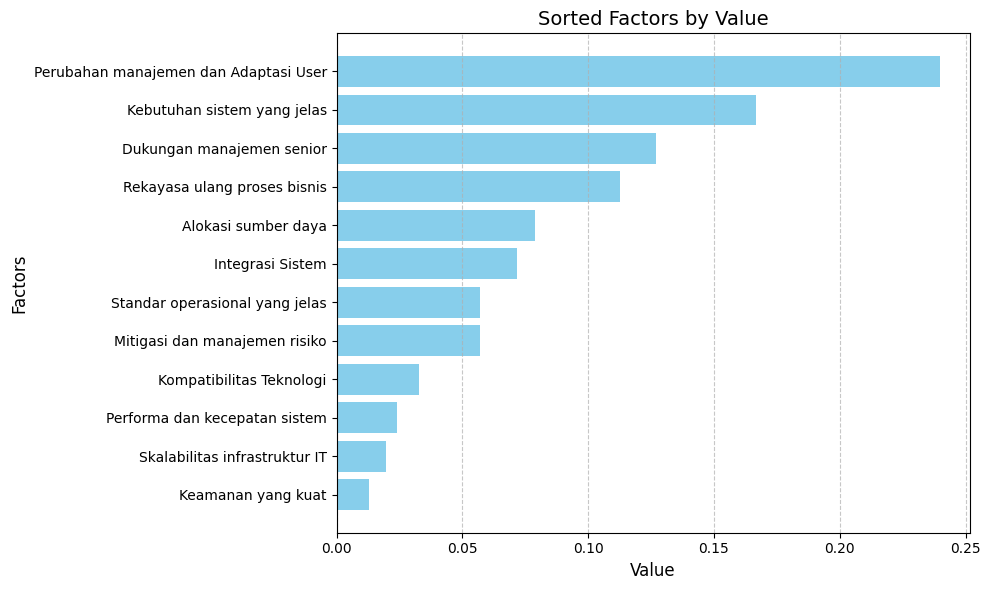

In [15]:
import matplotlib.pyplot as plt

# Data for visualization
labels = list(sorted_overall.keys())
values = list(sorted_overall.values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Factors', fontsize=12)
plt.title('Sorted Factors by Value', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


### Pairwise


In [16]:
matrixes = []

for _, row in ppt_cleaned_data.iterrows():
    print(row["1. Profil Responden"])
    matrix = build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced)
    matrixes.append(matrix)
    print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
print("average")
print(avg_matrix)

normalized_matrix = avg_matrix / avg_matrix.sum(axis=0)

print("normalized_matrix")
print(normalized_matrix)

Amelia, Sinaga, PT BPR Buana Agribisnis
[[1.         5.         3.        ]
 [0.2        1.         0.33333333]
 [0.33333333 3.         1.        ]]
Adi, Junianto, PT BPR Logo Karo asri
[[1.         3.         1.8       ]
 [0.33333333 1.         3.        ]
 [0.55555556 0.33333333 1.        ]]
nan
[[1.         0.33333333 3.        ]
 [3.         1.         5.        ]
 [0.33333333 0.2        1.        ]]
Dede, Gunawan, PT BPR Tata Asia
[[1.         5.         3.        ]
 [0.2        1.         1.8       ]
 [0.33333333 0.55555556 1.        ]]
Rizal, ., PD BPR Bank Daerah Kabupaten Kediri
[[1.         0.33333333 5.        ]
 [3.         1.         5.        ]
 [0.2        0.2        1.        ]]
Idrus, Afandi, PT Dimensi Kreasi Nusantara
[[1.  5.  5. ]
 [0.2 1.  5. ]
 [0.2 0.2 1. ]]
Yadi, Mulyadi, PT BPR Mitra Parahyangan
[[1.         0.2        3.        ]
 [5.         1.         5.        ]
 [0.33333333 0.2        1.        ]]
Siti, -, PT BPR Sinar Mas Pelita
[[1.  5.  5. ]
 [0.2 1.  

In [17]:
def build_matrix(row, pairs, criteria, response_scale):
    n = len(criteria)
    matrix = np.ones((n, n))  # Start with identity matrix
    for i, crit_a in enumerate(criteria):
        for j, crit_b in enumerate(criteria):
            if i < j:
                # print(i,j)
                pairwise_key = next(
                    (pair for pair in pairs if f"A: {crit_a}. B: {crit_b}" in pair), None
                )
                # print(pairwise_key)
                # print(pairwise_key in row)
                # print(row[pairwise_key])
                if pairwise_key and pairwise_key in row:
                    if row[pairwise_key] in response_scale:
                        weight = response_scale[row[pairwise_key]]
                    else: # fallback to 1 for empty answer
                        weight = 1

                    matrix[i, j] = weight
                    matrix[j, i] = 1 / weight
    return matrix


In [18]:
np.set_printoptions(precision=5, suppress=True)

In [19]:
cr_matrix = {}

In [20]:
matrixes = []

for i, row in ppt_cleaned_data.iterrows():
    matrix = build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced)
    matrixes.append(matrix)

    # cr = calculate_cr(matrix)
    cr_matrix[f"R{i+1}"] = [calculate_cr(matrix)]

avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]
print(cr_matrix)

end_matrix = np.ones((3, 3), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = calculate_cr(end_matrix_meaned)
print(cr)

{'R1': [0.03319921599842666], 'R6': [0.254120253723511], 'R9': [0.033199215998422064], 'R10': [0.1169059005672768], 'R13': [0.11690590056727833], 'R14': [0.2541202537235099], 'R16': [0.11690590056727948], 'R17': [0.2541202537235099], 'R18': [0.11690590056727833], 'R19': [0.4488302414286484]}
10
[[     1.          69.44444 273375.     ]
 [     0.0144       1.      140625.     ]
 [     0.           0.00001      1.     ]]
[[ 1.       4.11035 64.90123]
 [ 0.24329  1.      52.0021 ]
 [ 0.01541  0.01923  1.     ]]
0.07997087625051758
0.13788082112158204


## Process Pairwise


In [21]:
matrixes = []

for i, row in process_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    matrix = build_matrix(row, process_criteria_pairs, process_criteria,response_scale_balanced)
    matrixes.append(matrix)

    # cr = calculate_cr(matrix)
    # print(cr)
    cr_matrix[f"R{i+1}"].append(calculate_cr(matrix))

print(cr_matrix)

avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = calculate_cr(end_matrix_meaned)
print(cr)

{'R1': [0.03319921599842666, 0.353991847062368], 'R6': [0.254120253723511, 0.0998942818903214], 'R9': [0.033199215998422064, 0.5902801978527566], 'R10': [0.1169059005672768, 0.28345032638782874], 'R13': [0.11690590056727833, 0.2530672492591666], 'R14': [0.2541202537235099, 0.25306724925916396], 'R16': [0.11690590056727948, 0.7842147834441171], 'R17': [0.2541202537235099, 0.2199168056558407], 'R18': [0.11690590056727833, 0.7622681377617552], 'R19': [0.4488302414286484, 0.25306724925916396]}
10
[[      1.            0.0048     5625.         1041.66667]
 [    208.33333       1.      1366875.       759375.     ]
 [      0.00018       0.            1.            1.66667]
 [      0.00096       0.            0.6           1.     ]]
[[ 1.       0.26321  8.66025  5.6811 ]
 [ 3.79918  1.      34.19261 29.51985]
 [ 0.11547  0.02925  1.       1.13622]
 [ 0.17602  0.03388  0.88011  1.     ]]
0.009977375601849895
0.011085972890944326


## People Pairwise


In [22]:
matrixes = []

for i, row in people_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    matrix = build_matrix(row, people_criteria_pairs, people_criteria,response_scale_balanced)
    matrixes.append(matrix)

    cr_matrix[f"R{i+1}"].append(calculate_cr(matrix))


avg_matrix = np.mean(matrixes, axis=0)
print(cr_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)
    normalized_matrix = matrix / matrix.sum(axis=0)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = calculate_cr(end_matrix_meaned)
print(cr)

{'R1': [0.03319921599842666, 0.353991847062368, 0.18354750071820225], 'R6': [0.254120253723511, 0.0998942818903214, 0.4084727516765775], 'R9': [0.033199215998422064, 0.5902801978527566, 0.12245133553355399], 'R10': [0.1169059005672768, 0.28345032638782874, 0.1835475007181983], 'R13': [0.11690590056727833, 0.2530672492591666, 0.18210766405036785], 'R14': [0.2541202537235099, 0.25306724925916396, 0.17557736878573513], 'R16': [0.11690590056727948, 0.7842147834441171, 0.7732748533702144], 'R17': [0.2541202537235099, 0.2199168056558407, 0.28392808654849183], 'R18': [0.11690590056727833, 0.7622681377617552, 0.25306724925916496], 'R19': [0.4488302414286484, 0.25306724925916396, 0.18354750071820355]}
10
[[       1.          9375.        759375.             0.00018]
 [       0.00011        1.       3515625.             0.     ]
 [       0.             0.             1.             0.     ]
 [    5625.      12301875.       3796875.             1.     ]]
[[ 1.       9.83995 29.51985  0.11547]
 [ 

## Technology Pairwise


In [23]:
matrixes = []

for i, row in technology_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    # print(row)
    matrix = build_matrix(row, technology_criteria_pairs, technology_criteria,response_scale_balanced)
    matrixes.append(matrix)
    cr_matrix[f"R{i+1}"].append(calculate_cr(matrix))

print(cr_matrix)

avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    # print(matrix)
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = calculate_cr(end_matrix_meaned)
print(cr)

{'R1': [0.03319921599842666, 0.353991847062368, 0.18354750071820225, 0.25306724925916496], 'R6': [0.254120253723511, 0.0998942818903214, 0.4084727516765775, 0.18354750071819895], 'R9': [0.033199215998422064, 0.5902801978527566, 0.12245133553355399, 0.6218984137156236], 'R10': [0.1169059005672768, 0.28345032638782874, 0.1835475007181983, 0.12245133553355794], 'R13': [0.11690590056727833, 0.2530672492591666, 0.18210766405036785, 0.06742689066866933], 'R14': [0.2541202537235099, 0.25306724925916396, 0.17557736878573513, 0.2683581282408883], 'R16': [0.11690590056727948, 0.7842147834441171, 0.7732748533702144, 0.11459299139204075], 'R17': [0.2541202537235099, 0.2199168056558407, 0.28392808654849183, 0.10667673041348208], 'R18': [0.11690590056727833, 0.7622681377617552, 0.25306724925916496, 0.26835812824089056], 'R19': [0.4488302414286484, 0.25306724925916396, 0.18354750071820355, 0.26835812824089056]}
10
[[       1.             0.00003        0.             0.     ]
 [   30375.             

pembuka
anggota kel
latar belakang
pertanyaan penelitian
manfaat, state of the art
cbs
csf studi literatur
csf yg kita pilih
alur penelitian
hasil kuisioner (top 6 csf)
thank you slide


{'R1': [0.03319921599842666, 0.353991847062368, 0.18354750071820225, 0.25306724925916496], 'R6': [0.254120253723511, 0.0998942818903214, 0.4084727516765775, 0.18354750071819895], 'R9': [0.033199215998422064, 0.5902801978527566, 0.12245133553355399, 0.6218984137156236], 'R10': [0.1169059005672768, 0.28345032638782874, 0.1835475007181983, 0.12245133553355794], 'R13': [0.11690590056727833, 0.2530672492591666, 0.18210766405036785, 0.06742689066866933], 'R14': [0.2541202537235099, 0.25306724925916396, 0.17557736878573513, 0.2683581282408883], 'R16': [0.11690590056727948, 0.7842147834441171, 0.7732748533702144, 0.11459299139204075], 'R17': [0.2541202537235099, 0.2199168056558407, 0.28392808654849183, 0.10667673041348208], 'R18': [0.11690590056727833, 0.7622681377617552, 0.25306724925916496, 0.26835812824089056], 'R19': [0.4488302414286484, 0.25306724925916396, 0.18354750071820355, 0.26835812824089056]}


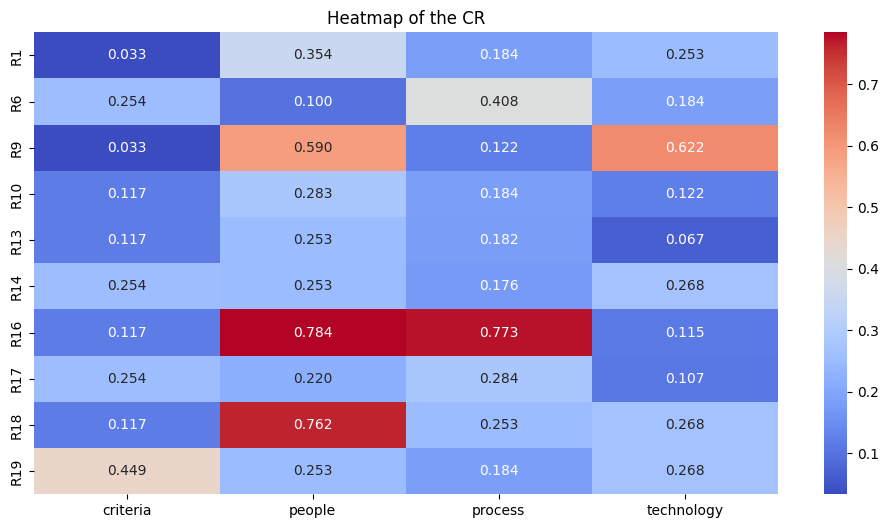

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print(cr_matrix)

# Create DataFrame
df = pd.DataFrame(cr_matrix, index=['criteria', 'people', 'process', 'technology'])

df_transposed = df.T

# Plot the heatmap with transposed data
plt.figure(figsize=(12, 6))  # Make the plot wider
sns.heatmap(df_transposed, annot=True, cmap='coolwarm', fmt='.3f', cbar=True)
plt.title("Heatmap of the CR")
plt.show()


In [25]:
for i, row in data.iterrows():
    print(f"R{i+1} : {row['1. Profil Responden']}")

# print(data)

R1 : Amelia, Sinaga, PT BPR Buana Agribisnis
R6 : Adi, Junianto, PT BPR Logo Karo asri
R9 : nan
R10 : Dede, Gunawan, PT BPR Tata Asia
R13 : Rizal, ., PD BPR Bank Daerah Kabupaten Kediri
R14 : Idrus, Afandi, PT Dimensi Kreasi Nusantara
R16 : Yadi, Mulyadi, PT BPR Mitra Parahyangan
R17 : Siti, -, PT BPR Sinar Mas Pelita
R18 : Krisna, -, PT BPR Mitra Parahyangan
R19 : Tiar, Nugraha, tiar@bprsinarmaspelita.com, PT BPR Sinar Mas Pelita


In [26]:
avg_cr1 = 0.0
avg_cr2 = 0.0
avg_cr3 = 0.0
avg_cr4 = 0.0
# print(cr_matrix)
for arr_cr in cr_matrix.values():
    avg_cr1 += arr_cr[0]
    avg_cr2 += arr_cr[1]
    avg_cr3 += arr_cr[2]
    avg_cr4 += arr_cr[3]

cr_criteria = avg_cr1/len(cr_matrix)
cr_people = avg_cr2/len(cr_matrix)
cr_process = avg_cr3/len(cr_matrix)
cr_tech = avg_cr4/len(cr_matrix)

cr_total = {
    'criteria': cr_criteria,
    'people': cr_people,
    'process': cr_process,
    'technology': cr_tech,
}

cr_total


{'criteria': 0.17452130368651408,
 'people': 0.38532181278324823,
 'process': 0.274952181137871,
 'technology': 0.2274735496423407}

In [27]:

import numpy as np

# Define the pairwise comparison matrix
matrix = np.array([
    [1.0, 0.07575, 0.02525, 0.04],
    [13.20168, 1.0, 0.01151, 0.656],
    [39.60503, 86.87191, 1.0, 58.09475],
    [25.0, 1.5244, 0.01721, 1.0]
])

# Step 1: Calculate the priority vector (weights)
# Normalize the matrix by dividing each element by the sum of its column
column_sums = np.sum(matrix, axis=0)
normalized_matrix = matrix / column_sums

# Compute the priority vector as the average of each row
priority_vector = np.mean(normalized_matrix, axis=1)

# Step 2: Compute lambda_max
# Multiply the original matrix by the priority vector
weighted_sum_vector = np.dot(matrix, priority_vector)

# Compute lambda_max as the ratio of the weighted sum vector to the priority vector
lambda_max = np.mean(weighted_sum_vector / priority_vector)

# Step 3: Compute the Consistency Index (CI)
n = matrix.shape[0]  # Number of criteria
CI = (lambda_max - n) / (n - 1)

# Step 4: Compute the Consistency Ratio (CR)
# Random Index (RI) values for n = 1 to 10
RI_values = [0.00, 0.00, 0.58, 0.90, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]
RI = RI_values[n]  # Select the RI based on the matrix size

CR = CI / RI if RI != 0 else 0  # Avoid division by zero for n=2

# Print the results
print("Priority Vector (Weights):", priority_vector)
print("Lambda_max:", lambda_max)
print("Consistency Index (CI):", CI)
print("Consistency Ratio (CR):", CR)


Priority Vector (Weights): [0.00954 0.05015 0.84848 0.09183]
Lambda_max: 6.59810336296673
Consistency Index (CI): 0.8660344543222432
Consistency Ratio (CR): 0.7732450485020028
